In [1]:
import torch
from transformers import BertTokenizer, BertModel
from torch.nn import CosineSimilarity
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [2]:
def visualize(distances, figsize=(10, 5), titles=None):
    ncols = len(distances)
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    for i in range(ncols):
        axes = ax[i] if ncols > 1 else ax
        distance = distances[i]     
        axes.imshow(distance, cmap=plt.cm.Blues)    
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))
        for j in range(distance.shape[0]):
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j][k], 3)),
                               ha="center", va="center", color="black")
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")
    fig.tight_layout()
    plt.show()

In [3]:
text_short = "Short Text."
text_long = "Long Text with real words such as armadillo and random sequence of chars such as huiefhuiwehf."
encoded_short = tokenizer_bert(text_short, return_tensors="pt")
output_short = model(**encoded_short)
encoded_long = tokenizer_bert(text_long, return_tensors="pt")
output_long = model(**encoded_long)
assert output_short["pooler_output"].shape == output_long["pooler_output"].shape
print("Shapes are equal.")
assert not torch.equal(output_short["pooler_output"], output_long["pooler_output"])
print("Results are different.")

Shapes are equal.
Results are different.


In [4]:
sentences = [
	"This fish can fly extremely well",
	"The fish is able to levitate",
	"Something random"
]
encodings = tokenizer_bert(sentences, padding=True, return_tensors="pt")
with torch.no_grad():
	embeds = model(**encodings)[0]

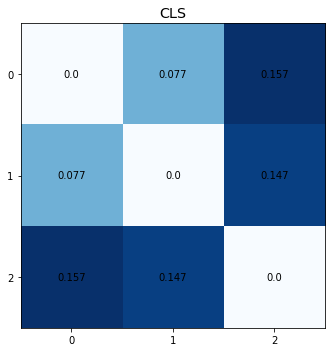

In [5]:
CLSs = embeds[:, 0, :]
normalized = f.normalize(CLSs, p=2, dim=1)
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.numpy()
visualize([cls_dist], titles=["CLS"])

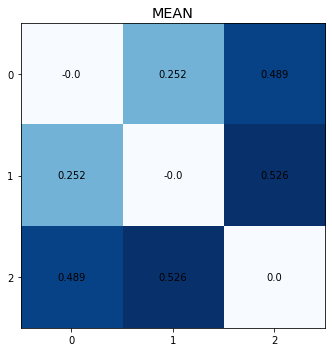

In [6]:
MEANS = embeds.mean(dim=1)
normalized = f.normalize(MEANS, p=2, dim=1)
mean_dist = normalized.matmul(normalized.T)
mean_dist = mean_dist.new_ones(mean_dist.shape) - mean_dist
mean_dist = mean_dist.numpy()
visualize([mean_dist], titles=["MEAN"])

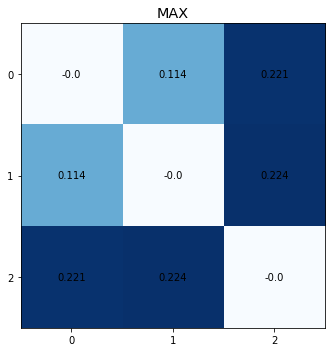

In [7]:
MAXS, _ = embeds.max(dim=1)
normalized = f.normalize(MAXS, p=2, dim=1)
max_dist = normalized.matmul(normalized.T)
max_dist = max_dist.new_ones(max_dist.shape) - max_dist
max_dist = max_dist.numpy()
visualize([max_dist], titles=["MAX"])